## Vector Autoregression

In [14]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import tight_layout

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

from scipy import stats
from scipy.stats import boxcox

from timeit import default_timer as timer
from dateutil.parser import parse
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)

pd.options.display.float_format = '{:.3f}'.format

plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = '17'

In [15]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),2)

def sum_million(x):    
    return round(((x.sum())/1000000.0),2)

def sum_thousand(x):    
    return round(((x.sum())/1000.0),2)

def media_agregada(x):    

    return round(((x.sum())/12.0),0)

def ignore_nans(a,b):
    index = ~a.isnull() & ~b.isnull()
    return a[index], b[index]

In [16]:
grupo = 'Adesão - Grande - Cooperativa Médica' 

grupo_csv = "ade_g_coopmed.csv"

#path = r'D:\TCC\TCC\codigos\preparacao_dados\analise_agrupadas\adesao\porte_grande\adesao_grande_cooperativa_medica' + '\\' + grupo_csv

ans = pd.read_csv(grupo_csv, sep=';', decimal= ',', encoding='mbcs')

ans.head()

,ano,cd_ops,trimestre,receita,despesa,benef,modalidade,port_ops,contratacao
0,2018,303976,2018Q1,29314392.257,23298026.978,27209,Cooperativa Médica,Grande,Adesao
1,2018,342084,2018Q1,100884002.783,71227129.017,50901,Cooperativa Médica,Grande,Adesao
2,2018,348295,2018Q2,4388045.611,4255788.457,6692,Cooperativa Médica,Grande,Adesao
3,2018,348295,2018Q3,4596013.001,4967336.847,6736,Cooperativa Médica,Grande,Adesao
4,2018,348295,2018Q4,4842097.207,3878879.670,7581,Cooperativa Médica,Grande,Adesao


In [17]:
ans_agrup = ans.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_billion(x),
                                                                    'despesa':lambda x: sum_billion(x),
                                                                    'benef': 'sum',
                                                                    'cd_ops':lambda x: x.nunique()})

ans_agrup['pct_despesa'] = ans_agrup.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_agrup.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_agrup = ans_agrup[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_agrup = ans_agrup[(ans_agrup.trimestre > '2017Q4') & (ans_agrup.trimestre < '2022Q1')]

ans_agrup[['n_ops','benef']] = ans_agrup[['n_ops','benef']].astype('int')

ans_agrup['benefm'] = ans_agrup['benef'] / 3.0

ans_agrup['receita_lag1'] = ans_agrup['receita'].shift(1)
ans_agrup['receita_lag2'] = ans_agrup['receita'].shift(2)
ans_agrup['receita_lag3'] = ans_agrup['receita'].shift(3)
ans_agrup['receita_lag4'] = ans_agrup['receita'].shift(4)
ans_agrup['receita_lag5'] = ans_agrup['receita'].shift(5)
ans_agrup['receita_lag6'] = ans_agrup['receita'].shift(6)

ans_agrup['despesa_lag1'] = ans_agrup['despesa'].shift(1)
ans_agrup['despesa_lag2'] = ans_agrup['despesa'].shift(2)
ans_agrup['despesa_lag3'] = ans_agrup['despesa'].shift(3)
ans_agrup['despesa_lag4'] = ans_agrup['despesa'].shift(4)
ans_agrup['despesa_lag5'] = ans_agrup['despesa'].shift(5)
ans_agrup['despesa_lag6'] = ans_agrup['despesa'].shift(6)

ans_agrup['despesa_lag1'] = ans_agrup['despesa'].shift(1)
ans_agrup['despesa_lag2'] = ans_agrup['despesa'].shift(2)
ans_agrup['despesa_lag3'] = ans_agrup['despesa'].shift(3)
ans_agrup['despesa_lag4'] = ans_agrup['despesa'].shift(4)
ans_agrup['despesa_lag5'] = ans_agrup['despesa'].shift(5)
ans_agrup['despesa_lag6'] = ans_agrup['despesa'].shift(6)

ans_agrup['receita_diff1'] = ans_agrup['receita'].diff(1)
ans_agrup['receita_diff2'] = ans_agrup['receita_diff1'].diff(1)
ans_agrup['receita_diff3'] = ans_agrup['receita_diff2'].diff(1)
ans_agrup['receita_diff4'] = ans_agrup['receita_diff3'].diff(1)

ans_agrup['despesa_diff1'] = ans_agrup['despesa'].diff(1)
ans_agrup['despesa_diff2'] = ans_agrup['despesa_diff1'].diff(1)
ans_agrup['despesa_diff3'] = ans_agrup['despesa_diff2'].diff(1)
ans_agrup['despesa_diff4'] = ans_agrup['despesa_diff3'].diff(1)

ans_agrup['benefm_diff1'] = ans_agrup['benefm'].diff(1)
ans_agrup['benefm_diff2'] = ans_agrup['benefm_diff1'].diff(1)
ans_agrup['benefm_diff3'] = ans_agrup['benefm_diff2'].diff(1)
ans_agrup['benefm_diff4'] = ans_agrup['benefm_diff3'].diff(1)

ans_agrup = ans_agrup[['trimestre',
                       'receita',
                       'receita_diff1',
                       'receita_diff2',
                       'receita_diff3',
                       'receita_diff4',
                       'despesa',
                       'despesa_diff1',
                       'despesa_diff2',
                       'despesa_diff3',
                       'despesa_diff4',
                       'benefm',
                       'benefm_diff1',
                       'benefm_diff2',
                       'benefm_diff3',
                       'benefm_diff4',
                       'n_ops']]

ans_agrup.set_index('trimestre', inplace=True)

ans_agrup

,receita,receita_diff1,receita_diff2,receita_diff3,receita_diff4,despesa,despesa_diff1,despesa_diff2,despesa_diff3,despesa_diff4,benefm,benefm_diff1,benefm_diff2,benefm_diff3,benefm_diff4,n_ops
trimestre,,,,,,,,,,,,,,,,
2018Q1,2.150,NaN,NaN,NaN,NaN,1.580,NaN,NaN,NaN,NaN,551754.667,NaN,NaN,NaN,NaN,38
2018Q2,2.160,0.010,NaN,NaN,NaN,1.640,0.060,NaN,NaN,NaN,555789.667,4035.000,NaN,NaN,NaN,38
2018Q3,2.290,0.130,0.120,NaN,NaN,1.850,0.210,0.150,NaN,NaN,559564.000,3774.333,-260.667,NaN,NaN,38
2018Q4,2.380,0.090,-0.040,-0.160,NaN,1.250,-0.600,-0.810,-0.960,NaN,564459.667,4895.667,1121.333,1382.000,NaN,38
2019Q1,2.370,-0.010,-0.100,-0.060,0.100,1.870,0.620,1.220,2.030,2.990,566867.333,2407.667,-2488.000,-3609.333,-4991.333,38
2019Q2,2.460,0.090,0.100,0.200,0.260,1.980,0.110,-0.510,-1.730,-3.760,576833.333,9966.000,7558.333,10046.333,13655.667,38
2019Q3,2.550,0.090,0.000,-0.100,-0.300,1.950,-0.030,-0.140,0.370,2.100,577843.000,1009.667,-8956.333,-16514.667,-26561.000,38
2019Q4,2.650,0.100,0.010,0.010,0.110,2.080,0.130,0.160,0.300,-0.070,585833.667,7990.667,6981.000,15937.333,32452.000,38
2020Q1,2.750,0.100,0.000,-0.010,-0.020,2.100,0.020,-0.110,-0.270,-0.570,625470.000,39636.333,31645.667,24664.667,8727.333,39


In [18]:
ans_agrup.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, 2018Q1 to 2021Q4
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   receita        16 non-null     float64
 1   receita_diff1  15 non-null     float64
 2   receita_diff2  14 non-null     float64
 3   receita_diff3  13 non-null     float64
 4   receita_diff4  12 non-null     float64
 5   despesa        16 non-null     float64
 6   despesa_diff1  15 non-null     float64
 7   despesa_diff2  14 non-null     float64
 8   despesa_diff3  13 non-null     float64
 9   despesa_diff4  12 non-null     float64
 10  benefm         16 non-null     float64
 11  benefm_diff1   15 non-null     float64
 12  benefm_diff2   14 non-null     float64
 13  benefm_diff3   13 non-null     float64
 14  benefm_diff4   12 non-null     float64
 15  n_ops          16 non-null     int32  
dtypes: float64(15), int32(1)
memory usage: 2.1+ KB


In [19]:
columns = ['receita','despesa','benefm']

columns_diff1 = ['receita_diff1','despesa_diff1','benefm_diff1']

columns_diff2 = ['receita_diff2','despesa_diff2','benefm_diff2']

columns_diff3 = ['receita_diff3','despesa_diff3','benefm_diff3']

columns_diff4 = ['receita_diff4','despesa_diff4','benefm_diff4']

#Correlação de Pearson entre receita e despesa (Antes da diferenciação)

stats.pearsonr(ans_agrup['receita'],ans_agrup['despesa'])

(0.8883356732978733, 4.300311285509653e-06)

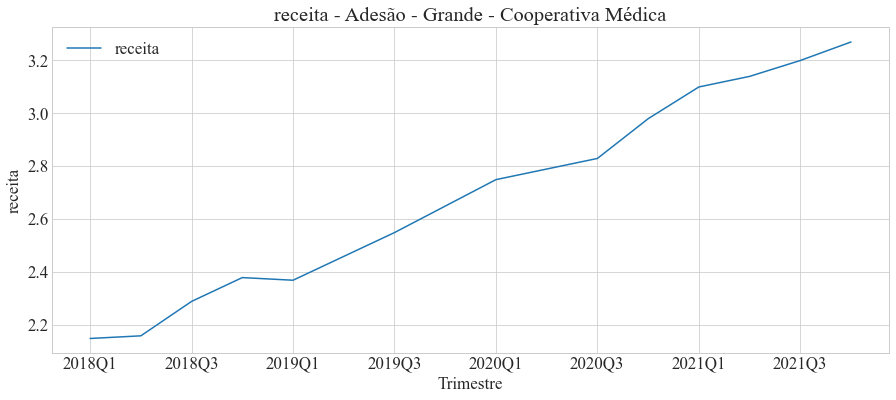

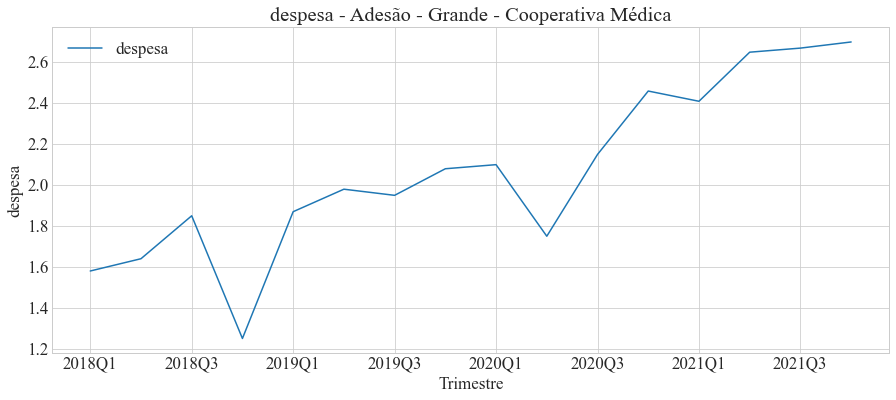

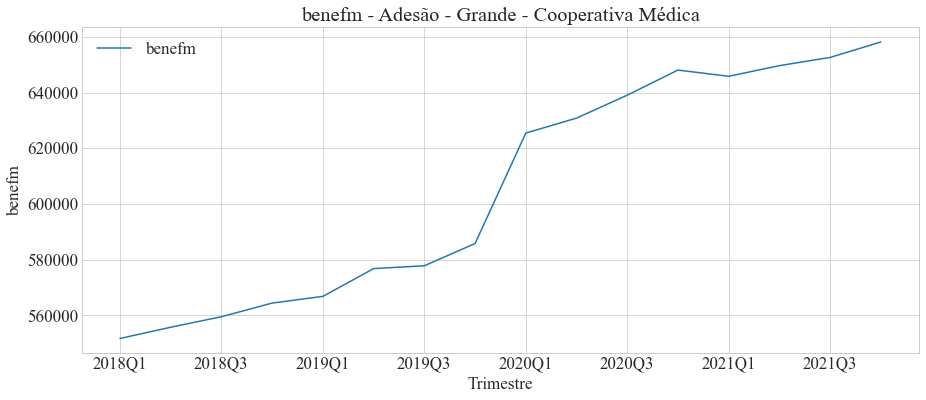

In [20]:
for c in ans_agrup[columns]:
    ans_agrup.plot(y = str(c), figsize=(15,6))
    plt.xlabel('Trimestre')
    plt.ylabel(c)
    plt.title(f'{str(c)} - '+ grupo)
    plt.show()

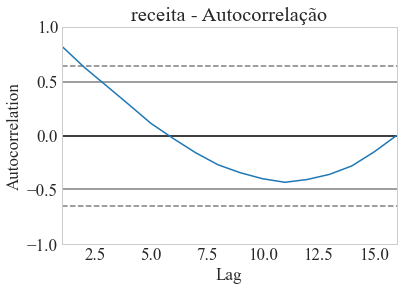

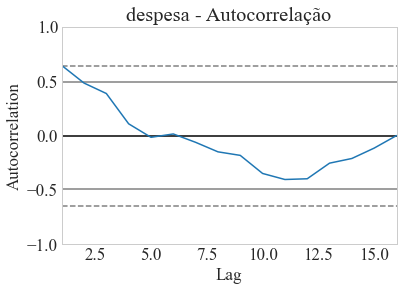

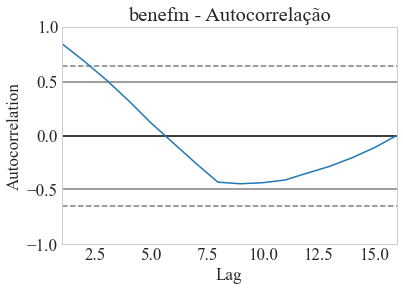

In [21]:
for c in ans_agrup[columns]:
    pd.plotting.autocorrelation_plot(ans_agrup[str(c)])
    plt.title(f'{str(c)} - Autocorrelação')
    plt.show()

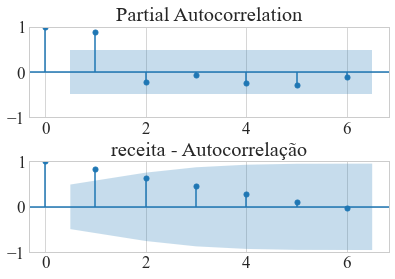

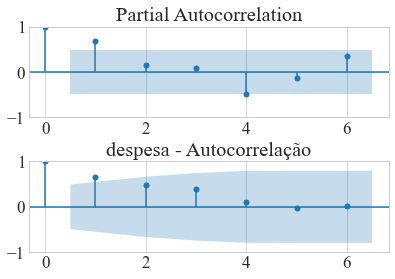

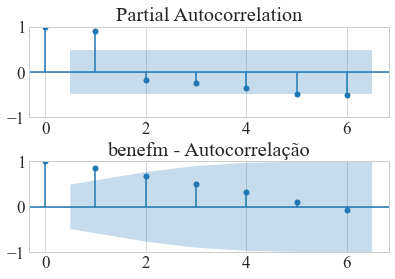

In [22]:
for c in ans_agrup[columns]:
    fig,axs = plt.subplots(2)
    fig,tight_layout()
    sm.graphics.tsa.plot_pacf(ans_agrup[str(c)], lags=6, ax=axs[0])
    plt.title(f'{str(c)} - Autocorrelação')   
    sm.graphics.tsa.plot_acf(ans_agrup[str(c)], lags=6, ax=axs[1])
    plt.title(f'{str(c)} - Autocorrelação')

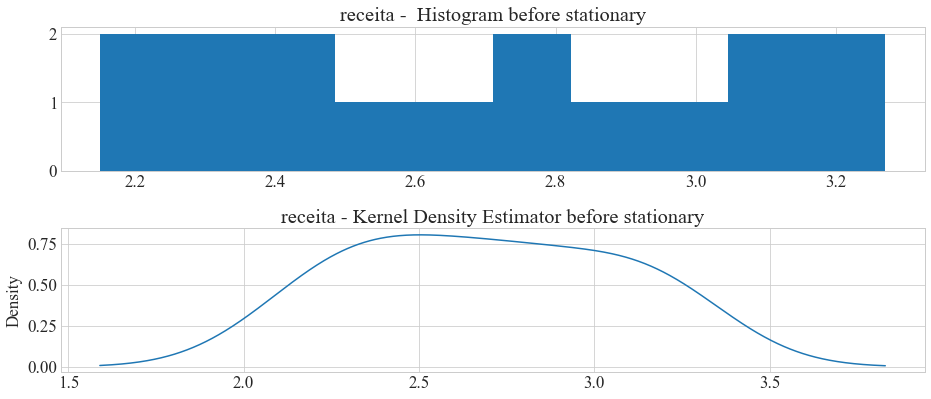

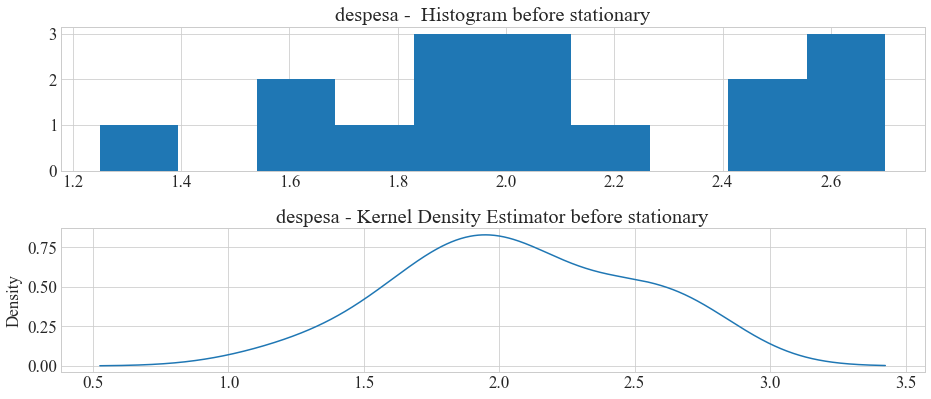

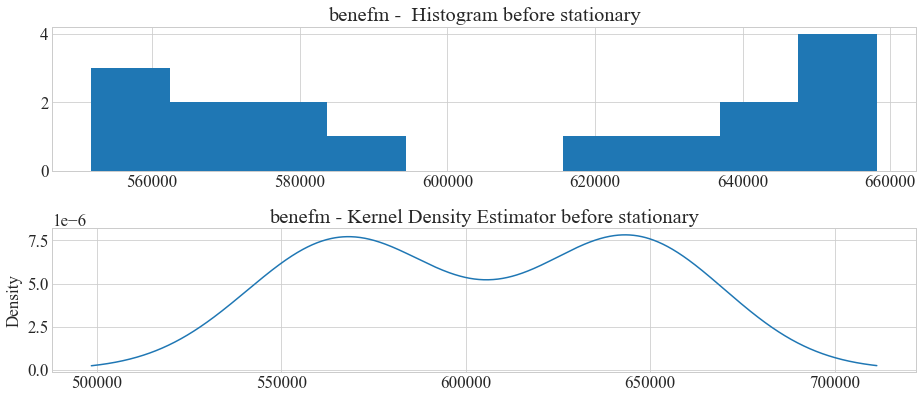

In [23]:
for c in ans_agrup[columns]:
    ans_agrup[str(c)].plot(figsize=(15,6))
    plt.figure(1, figsize=(15,6))
    plt.subplot(211)
    plt.title(f'{str(c)} -  Histogram before stationary')
    ans_agrup[str(c)].hist()
    plt.subplot(212)   
    ans_agrup[str(c)].plot(kind='kde')
    plt.title(f'{str(c)} - Kernel Density Estimator before stationary')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
    plt.show()

In [24]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def smape(y_true,y_pred):
        num = np.abs(np.subtract(y_true,y_pred))
        den = (np.abs(y_true) + np.abs(y_pred)) / 2
        ratio = num/den
        return ratio.mean()

    print(f'Mean_Squared_Error_(MSE) is : {mean_squared_error(y_true,y_pred)}')

    print(f'Root_Mean_Squared_Error_(RMSE) is : {mean_squared_error(y_true,y_pred, squared=False)}')

    print(f'Mean_Absolute_Error_(MAE) is : {mean_absolute_error(y_true,y_pred)}')

    print(f'Mean_Absolute_Percentage_Error (MAPE) is : {mean_absolute_percentage_error(y_true,y_pred)}')

    print(f'Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : {smape(y_true,y_pred)}')

    print(f'Coefficient of determination R^2 is : {r2_score(y_true,y_pred)}', end = '\n\n')

    return


def Augmented_Dickey_Fuller_Test_func(series, column_name):

    print(f'Results of Dickey-Fuller Test for column {column_name}')

    dftest = adfuller(series, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=[   'Test Statistic',
                                                'p-value',
                                                'No Lags Used',
                                                'Number of Observartions Used'])
    
    for key, value in dftest[4].items():
        
        dfoutput['Critical Value (%s)' %key] = value

    print(dfoutput)

    if dftest[1] <= 0.05:
        print('Conclusion:====>')
        print('Reject the null hypothesis')
        print('Data is stationary')
    else:
        print('Conclusion:====>')
        print('Fail to reject the null hypothesis')
        print('Data is non-stationary')

In [25]:
for name, column in ans_agrup[columns].iteritems():

    Augmented_Dickey_Fuller_Test_func(ans_agrup[name], name)

    print('\n')

Results of Dickey-Fuller Test for column receita
Test Statistic                 -0.035
p-value                         0.956
No Lags Used                    6.000
Number of Observartions Used    9.000
Critical Value (1%)            -4.473
Critical Value (5%)            -3.290
Critical Value (10%)           -2.772
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column despesa
Test Statistic                  2.344
p-value                         0.999
No Lags Used                    5.000
Number of Observartions Used   10.000
Critical Value (1%)            -4.332
Critical Value (5%)            -3.233
Critical Value (10%)           -2.749
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column benefm
Test Statistic                 -0.481
p-value                         0.896
No Lags Used                    0.000
Number of Observartions 

## Ajustes das variáveis

In [26]:
columns_test = columns_diff2

X = ans_agrup[columns_test]

train, test = X[0:-2], X[-2:]

#train_diff = train.diff()

#train_diff['receita'] = train_diff['receita'].diff()

#display(train_diff)

train.dropna(inplace = True)

display(train)

,receita_diff2,despesa_diff2,benefm_diff2
trimestre,,,
2018Q3,0.120,0.150,-260.667
2018Q4,-0.040,-0.810,1121.333
2019Q1,-0.100,1.220,-2488.000
2019Q2,0.100,-0.510,7558.333
2019Q3,0.000,-0.140,-8956.333
2019Q4,0.010,0.160,6981.000
2020Q1,0.000,-0.110,31645.667
2020Q2,-0.060,-0.370,-34268.667
2020Q3,0.000,0.750,2866.333


In [27]:
test

,receita_diff2,despesa_diff2,benefm_diff2
trimestre,,,
2021Q3,0.020,-0.220,-883.000
2021Q4,0.010,0.010,2598.667


In [28]:
for name, column in train[columns_test].iteritems():

    Augmented_Dickey_Fuller_Test_func(train[name], name)

    print('\n')

Results of Dickey-Fuller Test for column receita_diff2
Test Statistic                 -3.071
p-value                         0.029
No Lags Used                    4.000
Number of Observartions Used    7.000
Critical Value (1%)            -4.939
Critical Value (5%)            -3.478
Critical Value (10%)           -2.844
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column despesa_diff2
Test Statistic                 -4.836
p-value                         0.000
No Lags Used                    4.000
Number of Observartions Used    7.000
Critical Value (1%)            -4.939
Critical Value (5%)            -3.478
Critical Value (10%)           -2.844
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column benefm_diff2
Test Statistic                 -4.978
p-value                         0.000
No Lags Used                    0.000
Number of Observartions Used  

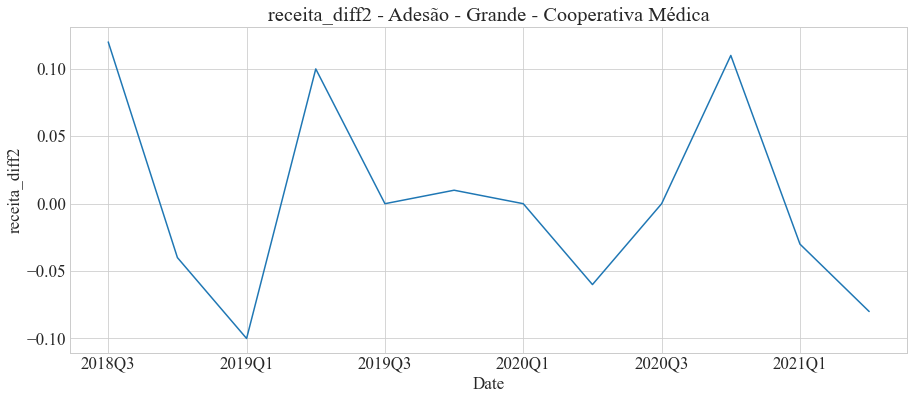

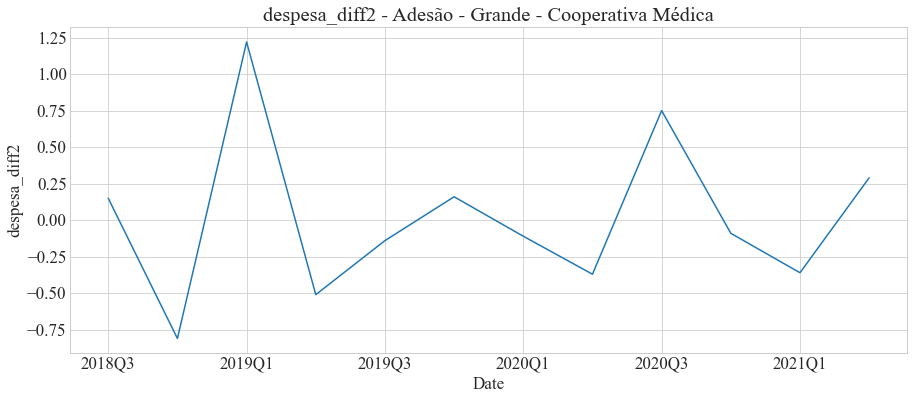

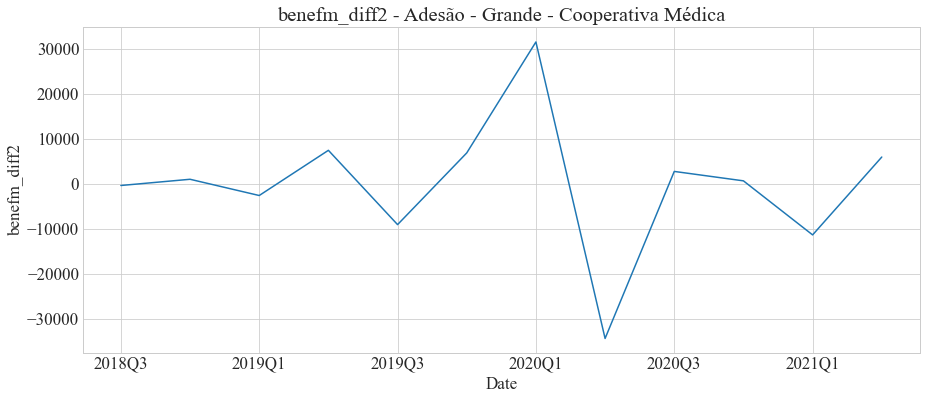

In [29]:
for c in train[columns_test]:
    train[str(c)].plot(figsize=(15,6))
    plt.xlabel('Date')
    plt.ylabel(c)
    plt.title(f'{str(c)} - '+ grupo)
    plt.show()

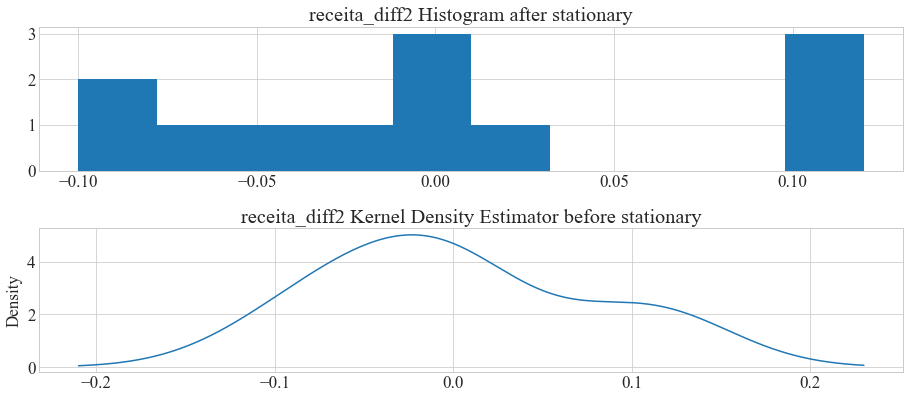

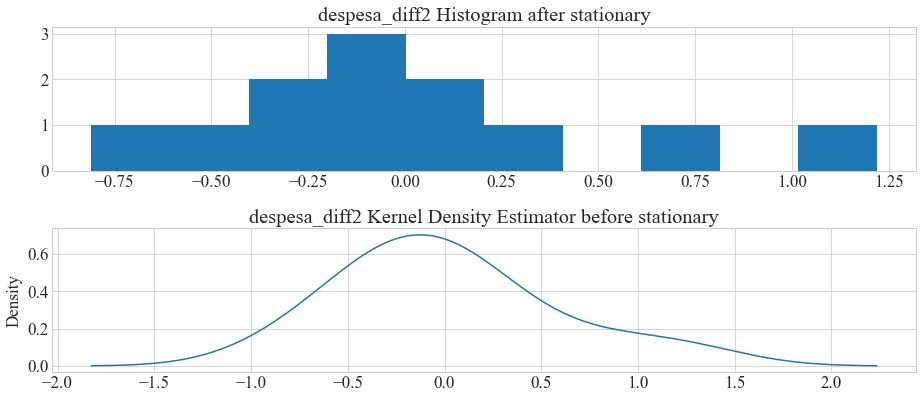

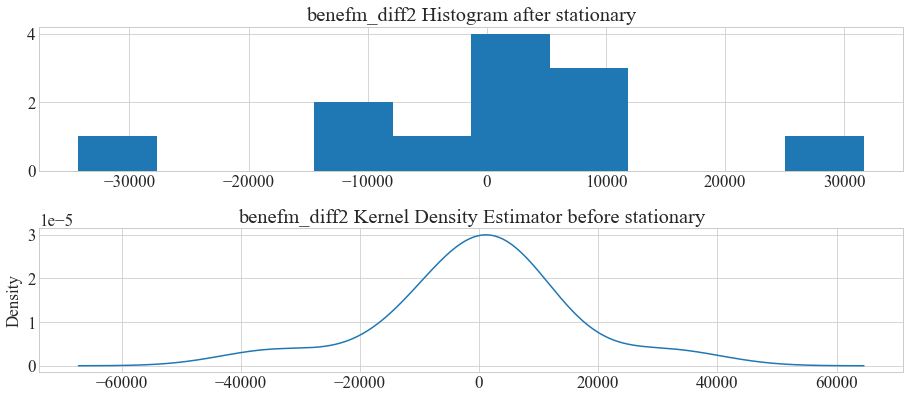

In [30]:
for c in train[columns_test]:
    train[str(c)].plot(figsize=(15,6))
    plt.figure(1, figsize=(15,6))
    plt.subplot(211)
    plt.title(f'{str(c)} Histogram after stationary')
    train[str(c)].hist()
    plt.subplot(212)
    train[str(c)].plot(kind='kde')
    plt.title(f'{str(c)} Kernel Density Estimator before stationary')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
    plt.show()

In [31]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegratrion_test(df):
    res = coint_johansen(df,-1,4)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]

    def adjust(val, length=6):
        return str(val).ljust(length)
    print('Column Name > Test Stat > C(95%)  =>  Signif \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2),9), '> ', adjust(cvt,8), '=> ', trace > cvt )

cointegratrion_test(train[columns_test])


Column Name > Test Stat > C(95%)  =>  Signif 
 ----------------------------------------
receita_diff2 >  269.83    >  24.2761  =>  True
despesa_diff2 >  134.35    >  12.3212  =>  True
benefm_diff2 >  25.06     >  4.1296   =>  True


In [32]:
for i in [1,2,3,4,5,6,7,8,9]:
    model = VAR(train)
    results = model.fit(i)
    print(f'Order: {i}, AIC: {results.aic}, BIC: {results.bic}')

Order: 1, AIC: 10.979094449876559, BIC: 11.413162020202055
Order: 2, AIC: 10.269228080567455, BIC: 10.904656775854953
Order: 3, AIC: -134.1852989768658, BIC: -133.52788371907837
Order: 4, AIC: -145.5802135259804, BIC: -145.19293601029122
Order: 5, AIC: -150.39650041574177, BIC: -150.76740225079106
Order: 6, AIC: -177.79942271506326, BIC: -179.77770775739674
Order: 7, AIC: -170.67774711557033, BIC: -175.8331666714402
Order: 8, AIC: -170.3231607785439, BIC: -181.83014150754593
Order: 9, AIC: -146.311050426218, BIC: -171.54990634351094


In [33]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[col + '_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[col].cumsum()
    return df_res

In [34]:
results = model.fit(2)
display(results.summary())
z = results.forecast(y=train[columns_test].values, steps=2)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Oct, 2022
Time:                     11:15:36
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    10.9047
Nobs:                     10.0000    HQIC:                   9.57216
Log likelihood:          -72.9143    FPE:                    78671.1
AIC:                      10.2692    Det(Omega_mle):         16012.8
--------------------------------------------------------------------
Results for equation receita_diff2
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.007292         0.008733            0.835           0.404
L1.receita_diff2         0.362824         0.272424            1.332           0.183
L1.despesa_diff2         0.010377       

In [35]:
df_pred = pd.DataFrame(z, columns=columns_test)
df_pred["new_index"] = range(14,16)
df_pred = df_pred.set_index('new_index')
df_pred.rename({'receita_diff2': 'receita_diff1',
                'despesa_diff2': 'despesa_diff1',
                'benefm_diff2': 'benefm_diff1'}, axis=1, inplace=True)
df_pred

,receita_diff1,despesa_diff1,benefm_diff1
new_index,,,
14,0.036,0.322,1768.503
15,0.046,-0.512,-6085.258


In [36]:
actual_df = ans_agrup[columns_diff1].iloc[:-2]

actual_df.reset_index(inplace=True)

actual_df = actual_df[['receita_diff1','despesa_diff1','benefm_diff1']]

display(actual_df)

display(df_pred)

res = inverse_diff(actual_df,df_pred)

res

,receita_diff1,despesa_diff1,benefm_diff1
0,NaN,NaN,NaN
1,0.010,0.060,4035.000
2,0.130,0.210,3774.333
3,0.090,-0.600,4895.667
4,-0.010,0.620,2407.667
5,0.090,0.110,9966.000
6,0.090,-0.030,1009.667
7,0.100,0.130,7990.667
8,0.100,0.020,39636.333
9,0.040,-0.350,5367.667


,receita_diff1,despesa_diff1,benefm_diff1
new_index,,,
14,0.036,0.322,1768.503
15,0.046,-0.512,-6085.258


,receita_diff1,despesa_diff1,benefm_diff1,receita_diff1_1st_inv_diff,despesa_diff1_1st_inv_diff,benefm_diff1_1st_inv_diff
new_index,,,,,,
14,0.036,0.322,1768.503,0.076,0.562,5598.170
15,0.046,-0.512,-6085.258,0.122,0.050,-487.088


In [37]:
df_pred = res[['receita_diff1_1st_inv_diff','despesa_diff1_1st_inv_diff','benefm_diff1_1st_inv_diff']]

df_pred.rename({'receita_diff1_1st_inv_diff': 'receita',
                'despesa_diff1_1st_inv_diff': 'despesa',
                'benefm_diff1_1st_inv_diff': 'benefm'}, axis=1, inplace=True)

actual_df = ans_agrup[columns].iloc[:-2]

actual_df.reset_index(inplace=True)

actual_df = actual_df[['receita','despesa','benefm']]

display(actual_df)

display(df_pred)

res = inverse_diff(actual_df,df_pred)

res

,receita,despesa,benefm
0,2.150,1.580,551754.667
1,2.160,1.640,555789.667
2,2.290,1.850,559564.000
3,2.380,1.250,564459.667
4,2.370,1.870,566867.333
5,2.460,1.980,576833.333
6,2.550,1.950,577843.000
7,2.650,2.080,585833.667
8,2.750,2.100,625470.000
9,2.790,1.750,630837.667


,receita,despesa,benefm
new_index,,,
14,0.076,0.562,5598.170
15,0.122,0.050,-487.088


,receita,despesa,benefm,receita_1st_inv_diff,despesa_1st_inv_diff,benefm_1st_inv_diff
new_index,,,,,,
14,0.076,0.562,5598.170,3.216,3.212,655269.170
15,0.122,0.050,-487.088,3.339,3.262,654782.081


In [38]:
train = ans_agrup[columns].iloc[:-2]

test = ans_agrup[columns].iloc[-2:]

for i in columns:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)], res[str(i)+'_1st_inv_diff'])

Evaluation metric for receita
Mean_Squared_Error_(MSE) is : 0.0024815913550920925
Root_Mean_Squared_Error_(RMSE) is : 0.04981557341928418
Mean_Absolute_Error_(MAE) is : 0.04238137046467605
Mean_Absolute_Percentage_Error (MAPE) is : 0.0130148529394851
Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : nan
Coefficient of determination R^2 is : -1.0257888612996768

Evaluation metric for despesa
Mean_Squared_Error_(MSE) is : 0.3045153057972402
Root_Mean_Squared_Error_(RMSE) is : 0.5518290548686614
Mean_Absolute_Error_(MAE) is : 0.5517404942641635
Mean_Absolute_Percentage_Error (MAPE) is : 0.2054757854429615
Symmetrical_Mean_Absolute_Percentage_Error (MAPE) is : nan
Coefficient of determination R^2 is : -1352.4013590988227

Evaluation metric for benefm
Mean_Squared_Error_(MSE) is : 9230539.737915145
Root_Mean_Squared_Error_(RMSE) is : 3038.1803333434877
Mean_Absolute_Error_(MAE) is : 3016.2108722314006
Mean_Absolute_Percentage_Error (MAPE) is : 0.0045998876672712335
Symmetrical_Mean_Abs

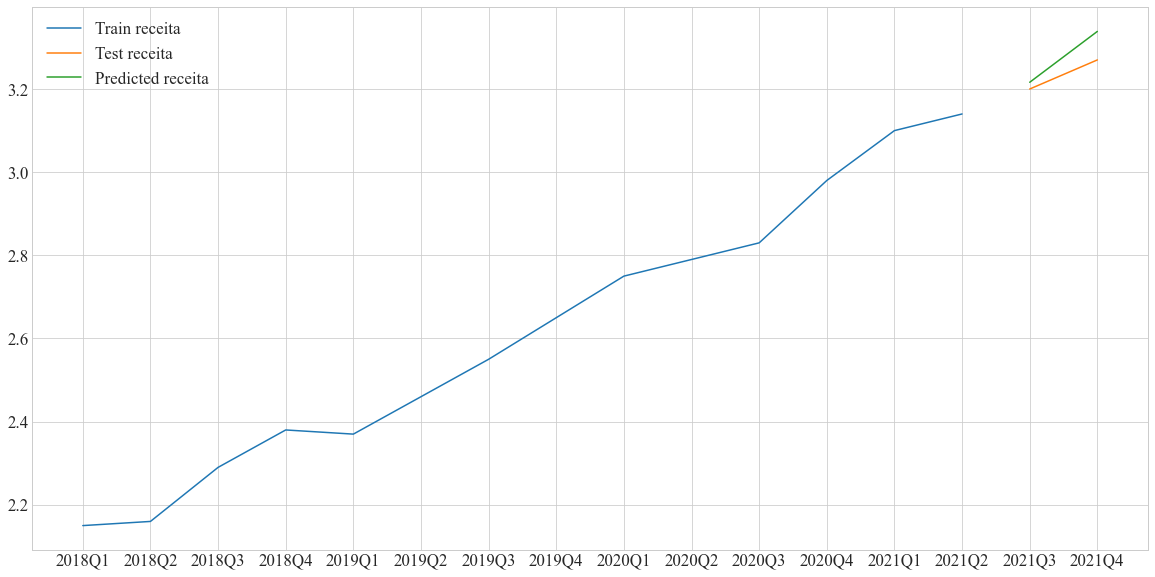

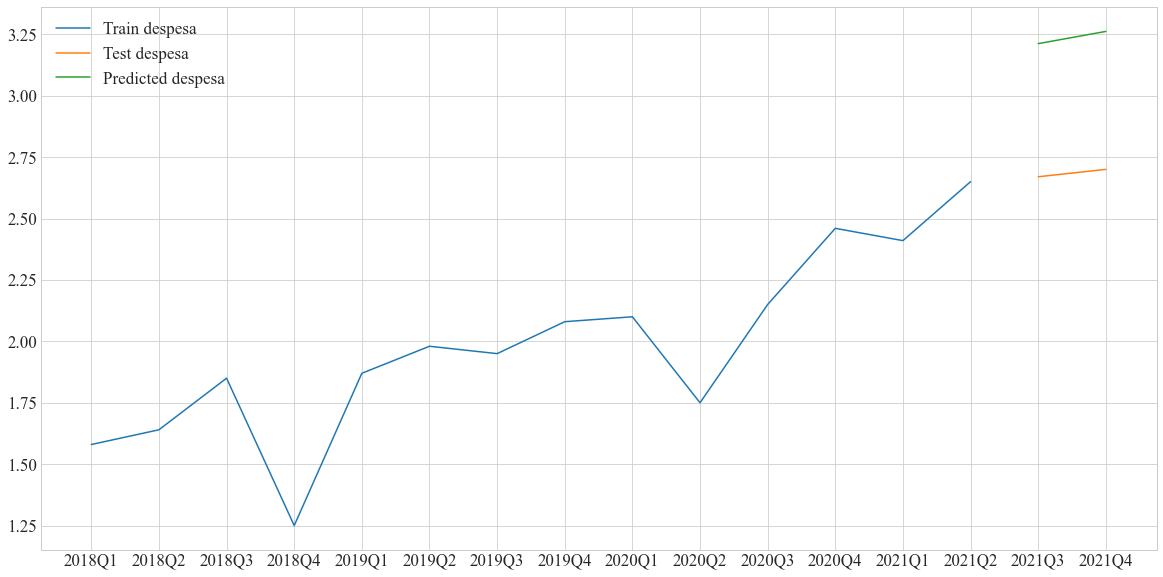

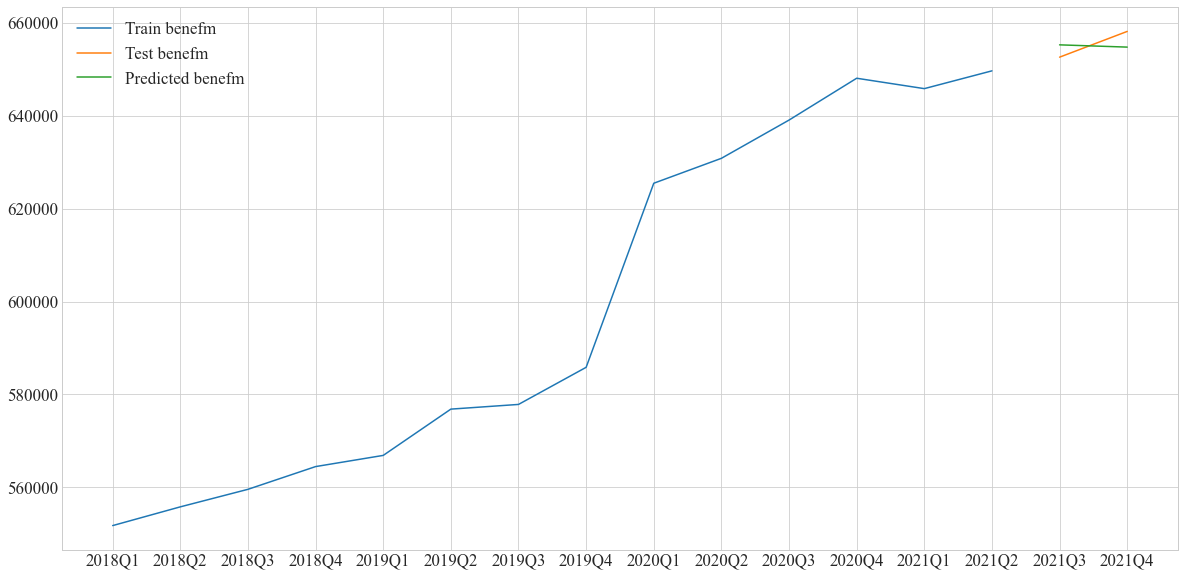

In [39]:
for i in columns:
    plt.rcParams['figure.figsize'] = [20,10]
    plt.plot(train[i], label='Train '+i)
    plt.plot(test[i], label='Test '+i)
    plt.plot(res[i+'_1st_inv_diff'], label = 'Predicted '+i)
    plt.legend(loc='best')
    plt.show()


## Predict

In [40]:
columns_test = columns_diff2

X = ans_agrup[columns_test]

X.dropna(inplace = True)

model = VAR(X)

#Parametros defindos na etapa de teste
var_regr = model.fit(2)
display(var_regr.summary())
y_pred = var_regr.forecast(y=X.values, steps=12)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Oct, 2022
Time:                     11:15:37
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    10.6426
Nobs:                     12.0000    HQIC:                   9.47988
Log likelihood:          -88.8461    FPE:                    29704.6
AIC:                      9.79405    Det(Omega_mle):         7483.54
--------------------------------------------------------------------
Results for equation receita_diff2
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.003320         0.006518            0.509           0.610
L1.receita_diff2         0.357521         0.214272            1.669           0.095
L1.despesa_diff2         0.029013       

In [41]:
df_pred = pd.DataFrame(y_pred, columns=columns_test)
df_pred["new_index"] = range(16,28)
df_pred = df_pred.set_index('new_index')
df_pred.rename({'receita_diff2': 'receita_diff1',
                'despesa_diff2': 'despesa_diff1',
                'benefm_diff2': 'benefm_diff1'}, axis=1, inplace=True)
df_pred

,receita_diff1,despesa_diff1,benefm_diff1
new_index,,,
16,0.010,-0.040,4401.822
17,-0.007,-0.072,-2056.722
18,-0.004,0.085,755.132
19,0.014,-0.028,1899.451
20,0.001,-0.050,-787.015
21,-0.004,0.051,1054.329
22,0.006,-0.016,781.450
23,0.002,-0.018,-345.331
24,0.001,0.024,1099.283


In [42]:
actual_df = ans_agrup[columns_diff1]

actual_df.reset_index(inplace=True)

actual_df = actual_df[['receita_diff1','despesa_diff1','benefm_diff1']]

display(actual_df)

display(df_pred)

res = inverse_diff(actual_df,df_pred)

res

,receita_diff1,despesa_diff1,benefm_diff1
0,NaN,NaN,NaN
1,0.010,0.060,4035.000
2,0.130,0.210,3774.333
3,0.090,-0.600,4895.667
4,-0.010,0.620,2407.667
5,0.090,0.110,9966.000
6,0.090,-0.030,1009.667
7,0.100,0.130,7990.667
8,0.100,0.020,39636.333
9,0.040,-0.350,5367.667


,receita_diff1,despesa_diff1,benefm_diff1
new_index,,,
16,0.010,-0.040,4401.822
17,-0.007,-0.072,-2056.722
18,-0.004,0.085,755.132
19,0.014,-0.028,1899.451
20,0.001,-0.050,-787.015
21,-0.004,0.051,1054.329
22,0.006,-0.016,781.450
23,0.002,-0.018,-345.331
24,0.001,0.024,1099.283


,receita_diff1,despesa_diff1,benefm_diff1,receita_diff1_1st_inv_diff,despesa_diff1_1st_inv_diff,benefm_diff1_1st_inv_diff
new_index,,,,,,
16,0.010,-0.040,4401.822,0.080,-0.010,9947.155
17,-0.007,-0.072,-2056.722,0.073,-0.082,7890.434
18,-0.004,0.085,755.132,0.069,0.003,8645.565
19,0.014,-0.028,1899.451,0.083,-0.025,10545.016
20,0.001,-0.050,-787.015,0.084,-0.075,9758.001
21,-0.004,0.051,1054.329,0.080,-0.023,10812.331
22,0.006,-0.016,781.450,0.086,-0.040,11593.780
23,0.002,-0.018,-345.331,0.088,-0.057,11248.449
24,0.001,0.024,1099.283,0.089,-0.033,12347.732


In [43]:
df_pred = res[['receita_diff1_1st_inv_diff','despesa_diff1_1st_inv_diff','benefm_diff1_1st_inv_diff']]

df_pred.rename({'receita_diff1_1st_inv_diff': 'receita',
                'despesa_diff1_1st_inv_diff': 'despesa',
                'benefm_diff1_1st_inv_diff': 'benefm'}, axis=1, inplace=True)

actual_df = ans_agrup[columns]

actual_df.reset_index(inplace=True)

actual_df = actual_df[['receita','despesa','benefm']]

display(actual_df)

display(df_pred)

res = inverse_diff(actual_df,df_pred)

res

,receita,despesa,benefm
0,2.150,1.580,551754.667
1,2.160,1.640,555789.667
2,2.290,1.850,559564.000
3,2.380,1.250,564459.667
4,2.370,1.870,566867.333
5,2.460,1.980,576833.333
6,2.550,1.950,577843.000
7,2.650,2.080,585833.667
8,2.750,2.100,625470.000
9,2.790,1.750,630837.667


,receita,despesa,benefm
new_index,,,
16,0.080,-0.010,9947.155
17,0.073,-0.082,7890.434
18,0.069,0.003,8645.565
19,0.083,-0.025,10545.016
20,0.084,-0.075,9758.001
21,0.080,-0.023,10812.331
22,0.086,-0.040,11593.780
23,0.088,-0.057,11248.449
24,0.089,-0.033,12347.732


,receita,despesa,benefm,receita_1st_inv_diff,despesa_1st_inv_diff,benefm_1st_inv_diff
new_index,,,,,,
16,0.080,-0.010,9947.155,3.350,2.690,668110.155
17,0.073,-0.082,7890.434,3.424,2.608,676000.589
18,0.069,0.003,8645.565,3.492,2.611,684646.154
19,0.083,-0.025,10545.016,3.575,2.586,695191.170
20,0.084,-0.075,9758.001,3.659,2.512,704949.172
21,0.080,-0.023,10812.331,3.739,2.488,715761.502
22,0.086,-0.040,11593.780,3.825,2.449,727355.283
23,0.088,-0.057,11248.449,3.913,2.391,738603.732
24,0.089,-0.033,12347.732,4.002,2.358,750951.464


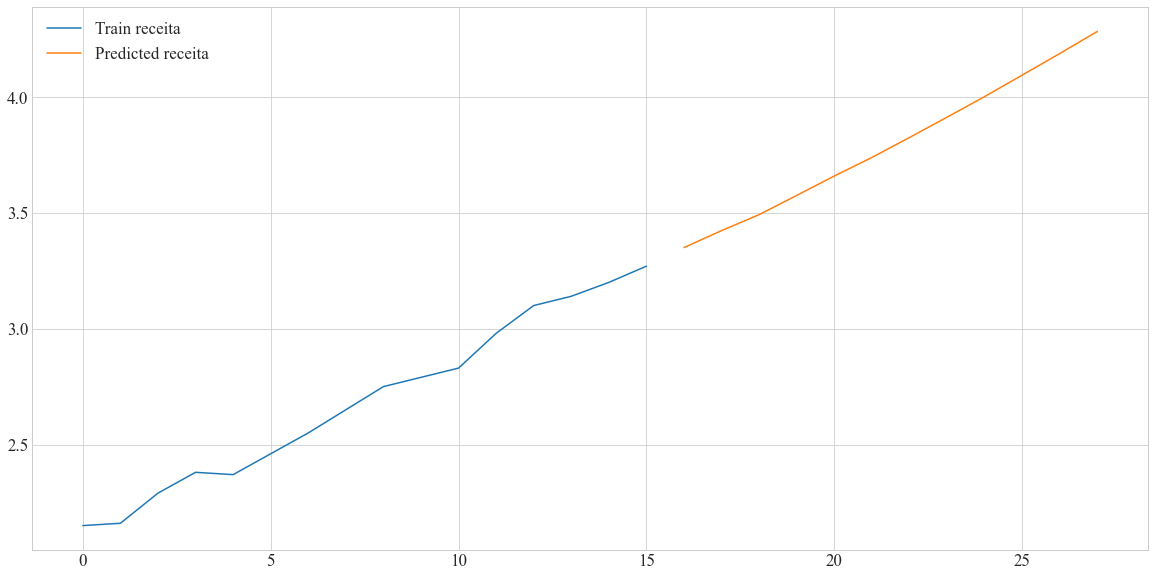

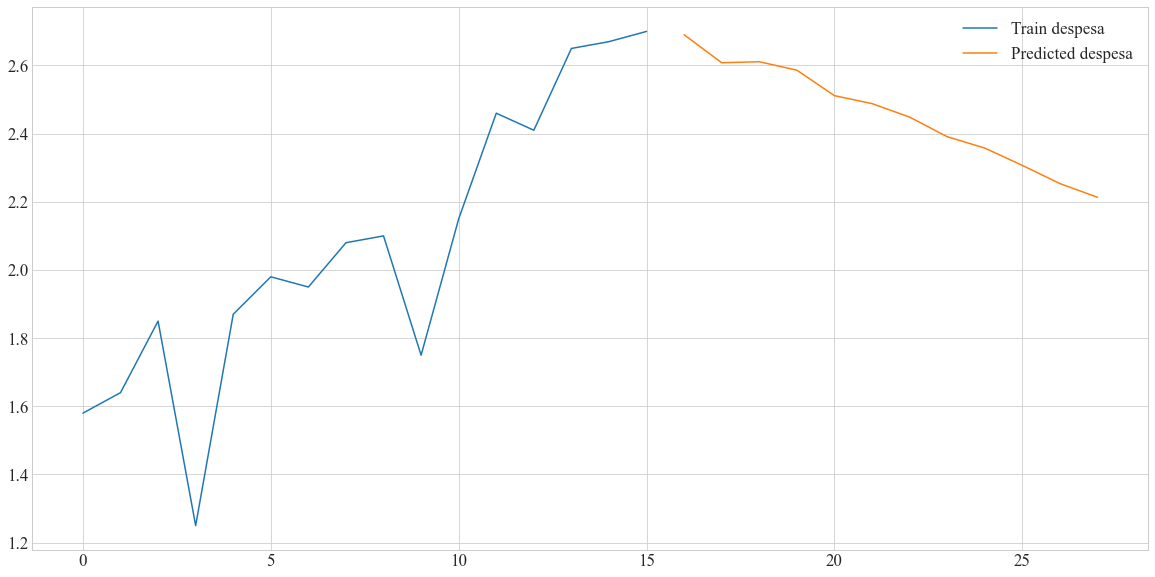

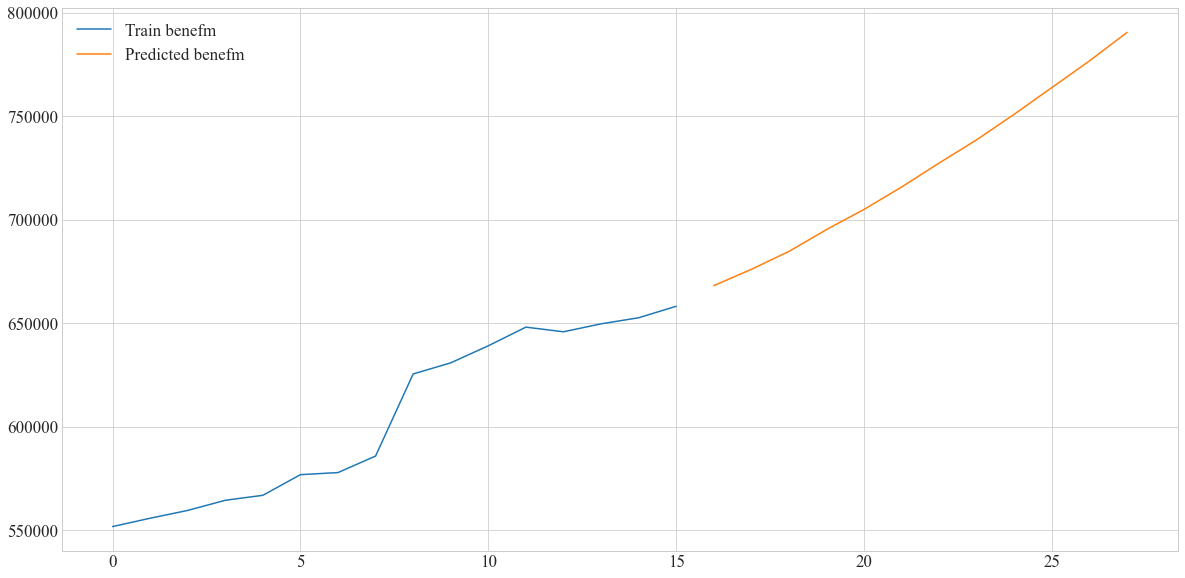

In [44]:
for i in columns:
    plt.rcParams['figure.figsize'] = [20,10]
    plt.plot(actual_df[i], label='Train '+i)
    #plt.plot(test[i], label='Test '+i)
    plt.plot(res[i+'_1st_inv_diff'], label = 'Predicted '+i)
    plt.legend(loc='best')
    plt.show()